In [1]:
library("purrr")
library("tidyverse")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Consider this example from Think Stats 2e (https://greenteapress.com/wp/think-stats-2e/):

You operate a casino and a player at one of your craps tables is winning. You suspect the player has employed a crooked die. You collect the following data for the players first 60 rolls with the die in question.

In [5]:
observed_data <- tribble(
  ~die_roll, ~count,
  1,          8,
  2,          9,
  3,         19,
  4,          5,
  5,          8,
  6,          11
)

observed_data

die_roll,count
<dbl>,<dbl>
1,8
2,9
3,19
4,5
5,8
6,11


Let's select a "test statistic" quantify how the observed data deviates from what we would expect on average from a fair die. Then we can find the null distribution of the test statistic and leverage that distribution to investigate the fairness of the suspicious die.

The following is a table that represents a fair die:

In [7]:
fair_die <- tribble(
  ~die_roll,
  1,
  2,
  3,
  4,
  5,
  6
)

fair_die

die_roll
<dbl>
1
2
3
4
5
6


We can use the slice_sample with replace = TRUE to simulate a "n" dice rolls.

In [8]:
slice_sample(fair_die, n = 10, replace = TRUE)

die_roll
<dbl>
6
4
5
3
1
5
3
6
6


The following is a function that calcuates the absolute deviance for a set of "n" rolls from what we would expect from a fair dice *on average*.

```r
abs_deviance = function(roll_frequencies) {
    n = sum(roll_frequencies)
    expected = n / 6
    abs(roll_frequencies - expected) |> sum()
}

```

In [9]:
abs_deviance = function(roll_frequencies) {
    n = sum(roll_frequencies)
    expected = n / 6
    abs(roll_frequencies - expected) |> sum()
}

observed_data |> summarize(abs_dev = abs_deviance(count))


abs_dev
<dbl>
20


The `purrr` code below generates simulates rolling a fair die 60 times for 1,000 iterations.

```r
n_iterations = 1000
n_rolls = 60

1:n_iterations |> map_dfr(~slice_sample(fair_die, n = 60, replace = TRUE), .id = 'replicate')

```

Run this code and collect the output in a table called `simulated_data`.

In [10]:
n_iterations = 1000
n_rolls = 60

simulated_data = 1:n_iterations |> map_dfr(~slice_sample(fair_die, n = 60, replace = TRUE), .id = 'replicate')
simulated_data |> nrow()
simulated_data |> head()

[1] 60000

replicate,die_roll
<chr>,<dbl>
1,4
1,5
1,3
1,5
1,2
1,6


Now we are ready to calculate the null distribution of our test statistic!

Using `simulated_data`,
1. `group_by` the `replicate` variable (add `.drop = FALSE` to make sure you include zero frequency counts),
2. `count` the frequency of `die_roll`. Last, 
3. `summarize` each group using the `abs_deviance` function from above. Call you new column `abs_dev`.

Capture the output into a table called `abs_dev_null_dist`.

In [11]:
abs_devian <- simulated_data |> group_by(replicate, .drop = FALSE) |> 
    count(die_roll) |> # count frequency
    summarize(abs_dev = abs_deviance(n))

abs_devian |> head()

replicate,abs_dev
<chr>,<dbl>
1,10
10,8
100,14
1000,8
101,16
102,10


Plot a histogram of abs_dev. Use geom_vline to show the positon of our the test statistic calculated from the suspicious die.

Can you calculate a "p-value" for our suspicous die using the null distribution and the observed test statistic?

In [12]:
abs_dev_null_dist |>
mutate(extreme = abs_dev >= 20) |>
summarize(p_value = sum(extreme) / n())

ERROR: Error in eval(expr, envir, enclos): object 'abs_dev_null_dist' not found


Redo the steps above but this time use the [Chi square](https://en.wikipedia.org/wiki/Chi-squared_test) statistic. The **Chi square** test statistic simply quantifies the sum of squared differences from expected values divided by the expected value.

You can re-use `simulated_data`.

Here is a function in `R`:

```r
chi_square = function(roll_frequencies) {
    n = sum(roll_frequencies)
    expected = n / 6
    sum((roll_frequencies - expected)**2 / expected)
}

```

specify() allows you to specify the variable, or relationship between variables, that you’re interested in.<br />
hypothesize() allows you to declare the null hypothesis.<br />
generate() allows you to generate data reflecting the null hypothesis.<br />
calculate() allows you to calculate a distribution of statistics from the generated data to form the null distribution.

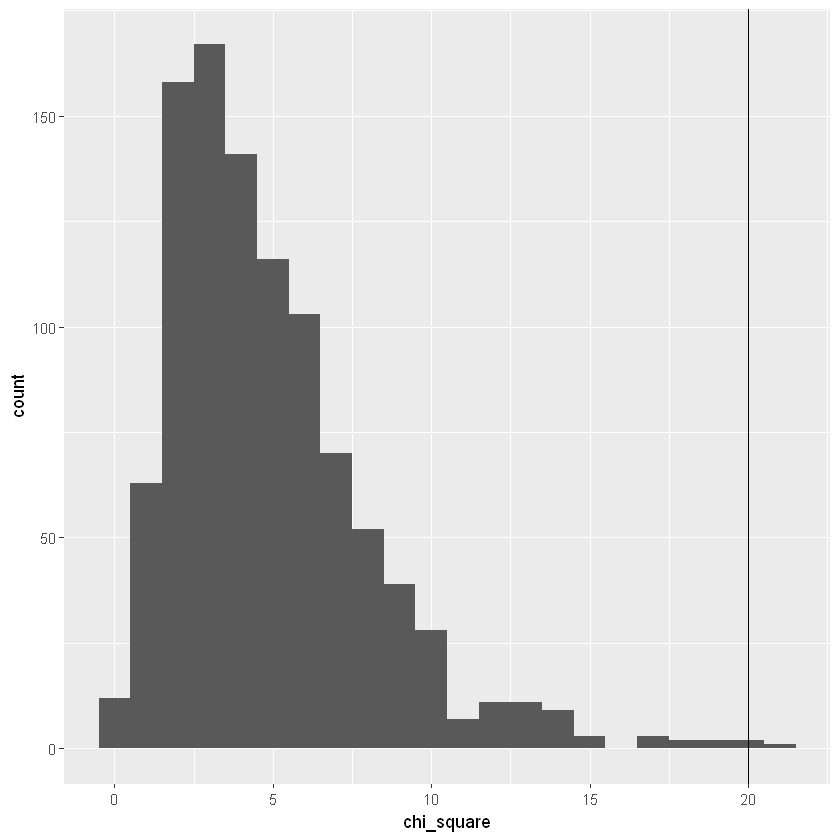

In [15]:
chi_square = function(roll_frequencies) {
n = sum(roll_frequencies)
expected = n / 6
sum((roll_frequencies - expected) ** 2 / expected)

}

chi_square_null_dist = simulated_data |>
group_by(replicate, .drop = FALSE) |>
count(die_roll) |>
summarize(chi_square = chi_square(n))

ggplot(chi_square_null_dist, aes(x = chi_square)) +
geom_histogram(binwidth = 1) +
geom_vline(xintercept = 20)

Is the "p-value" using the Chi square test statistic lower or higher than that calcuated using "absolute deviance" as the test statistic?

In [14]:
chi_square_null_dist |>
mutate(extreme = chi_square >= 20) |>
summarize(p_value = sum(extreme) / n())

p_value
<dbl>
0.001
